# Charon4 txt to Python
This script loads the data exported with charon4. The following screenshot shows the expected settings while exporting.

<img src=".\pictures\Charon4_export_window_txt.png" alt="drawing" width="500"/>

The results of this script are stored in `..\Alsdorf\Daten\my_database`. The goal of this database is to contain all data in an easy to read format.

In [1]:
version="v1_1"
# Changelog
#v1_0: has a nice overviwe at the end
#v1_1: add temp data from daniel to data_2019; length are int now
#v1_2: seperated this notebook into different ones

import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import date, timedelta
from collections import defaultdict
from collections import Counter
import matplotlib.patches as patches
import matplotlib.dates as mdates


# To-Do
# Im Plot am Ende genaues Datum markieren, ab dem es kaum Daten gibt

In [2]:
# Input
#path to working directory
#mit \[-]\ im Pfad funktioniert die get_abspath Funktion nicht
path_to_controller=r"..\Alsdorf\Daten\Charon4\charon4_export_as_txt"
data_save=True # True False; data saving takes about 10 min.
plot_save=True # True False

In [3]:
#############Input###################################
# I think the inputs dont work. Using all is the best way at the moment
channels=[1,2,3,4,5,6,7,8] #[1,2,3,4,5,6,7,8]
years=[2019,2020,2021] #[2019,2020,2021] # 2018 is imported seperate from another data format
months=[1,2,3,4,5,6,7,8,9,10,11,12] #[1,2,3,4,5,6,7,8,9,10,11,12]
################################################

controller=3188 # 3188: Alsdorf

# generate all requested paths, some paths may be empty
paths_for_activate={}
for year in years:
    for channel in channels:
        for month in months:
            paths_for_activate[f"temp_ch{channel}_year{year}_month{month}"] = path_to_controller + f"\Controller\{controller}\{channel}\Temperature Data\{year}\{month}"

#paths_for_activate

In [4]:
def get_abspath(basepath):
    """Get the files you need to import into your script with Path
    Returns a list of all filepaths (or folderpaths) of the files (or folders) in a repository.
    The repository is given this function with basepath.
    """
    df_list = []
    basepath = glob.glob(basepath)
    for entry in basepath:
        df_list.append(entry)
    return (df_list)

def import_temp_to_df(path):
    """"""
    #print(path)
    # error_bad_lines, needed for data of 2018, where the length of the cable changes
    # the data is loast at the moment, by adding columns / changing the data file the data could be imported
    # I think this data wont be important anyway
    df = pd.read_csv(path,skiprows=7,decimal=".",delimiter="\t",index_col=0,error_bad_lines=False,warn_bad_lines=False)
    df = df.drop(df.columns[0:2],axis=1)
    df.index.names = ['Date']
    df.index = pd.to_datetime(df.index, infer_datetime_format=True)
    df.rename(columns=lambda x: int(float(x)), inplace=True)
    df.columns.names=["Length [m]"]
    return df

In [5]:
%%time
#Wall time: 1min 54s
# Import Data and a bit of analysis
# dic erstellen mit 0 und 1 für jeden Monat pro Jahr und rein schreiben, ob dort Daten sind

# maybe its best to store not everything in one variable, not sure if thats True. 
# Make some thinks like plots a bit costiler

# see here why defaultdict is used:
# https://stackoverflow.com/questions/44992106/how-do-i-create-a-nested-dictionary-under-a-key-that-is-yet-to-exist
#data_2018=defaultdict(dict)
data_2019=defaultdict(dict)
data_2020=defaultdict(dict)
data_2021=defaultdict(dict)

# Create dict to count for which month data is avaible
#df=pd.DataFrame(index=months,columns=years)
#df.index.names = ['Month']
data_for_month_avaible={} #keys are channels
for channel in channels:
    data_for_month_avaible[channel] = pd.DataFrame(index=months,columns=years)
    data_for_month_avaible[channel].index.names = ['Month']

for name in paths_for_activate.keys(): # loop for every channel of every month
    my_path=paths_for_activate[name] + "\*"
    my_path_to_file=get_abspath(my_path)

    # get info about data from name
    partition1=name.partition("_year")[-1].partition("_month")
    year=partition1[0]
    month=partition1[-1]
    channelnumber=name.partition("_year")[0].partition("temp_ch")[-1]

    # check if the month folder contains more than one file 
    if len(my_path_to_file) > 1:
        data_for_month_avaible[int(channelnumber)][int(year)][int(month)]=1
        if name != "temp_ch2_year2019_month7":
            print("one months contains more than one file, script should be checked! Only encountered this ones")
            print(name)
        # adaption of script
        # Import Data, one option
        one_file=import_temp_to_df(my_path_to_file[0])
        for i in range(1,len(my_path_to_file)):
            additional_files=import_temp_to_df(my_path_to_file[i])
            #display(additional_files)
            #display(one_file)
            one_file=pd.concat([one_file,additional_files],axis=0)
            #display(one_file)
        
        ## Store Data in dic - best would be putting this in a user-defined-function
        # or creating an if with >=1
        #if year == "2018":
        #    data_2018[channelnumber][month] = one_file
        
        if year == "2019":
            data_2019[channelnumber][month] = one_file

        if year == "2020":
            data_2020[channelnumber][month] = one_file

        if year == "2021":
            data_2021[channelnumber][month] = one_file
    
    if len(my_path_to_file) == 0: # wenn pfad zu keinem file führt dann wird leere Liste returned
        data_for_month_avaible[int(channelnumber)][int(year)][int(month)]=0
    
    if len(my_path_to_file) == 1:
        data_for_month_avaible[int(channelnumber)][int(year)][int(month)]=1
        
        # Import Data, second option
        one_file=import_temp_to_df(my_path_to_file[0])

        ## Store Data in dic
        #if year == "2018":
        #    data_2018[channelnumber][month] = one_file
        
        if year == "2019":
            data_2019[channelnumber][month] = one_file

        if year == "2020":
            data_2020[channelnumber][month] = one_file

        if year == "2021":
            data_2021[channelnumber][month] = one_file

Wall time: 2min 14s


In [6]:
%%time
#Wall time: 41.3 s
# Import data from daniel
def import_data_Daniel(path):
    """import for data from sciebo Eduardschacht repository
    copied from compare script
    """
    df = pd.read_csv(path,delimiter = ',',index_col=0, header=7 )
    df = df.drop(df.columns[[0,1]], axis=1)
    df.index=pd.to_datetime(df.index, dayfirst = True).tz_localize(None)
    df.index=df.index.astype(str) # same column format as other dataframe
    df=df.transpose() # for having the same format as the other dataframe
    df.index=df.index.astype(float) #make depth to int
    df.index=df.index.astype(int) #make depth to int
    df.index.names = ['Depth [m]']
    df.columns.names=["Length [m]"]
    return df

def put_files_in_dataframe(list_of_paths,import_function):
    """
    merges files in one dataframe using an import_function (user-defined-functiom) in a list_of paths (list)
    copied from compare script
    """
    # Import Data
    dic={}
    for path in list_of_paths:
        dic[path]=import_function(path)

    # Merge files into one dataframe
    dic_concat=pd.concat(dic.values(),axis=1)

    return dic_concat

# Import files
paths_to_working_dir=r"..\Alsdorf\Daten"
daniel_ch1_paths=get_abspath(paths_to_working_dir + r"\Betrieb2019\Ch1\*")
daniel_ch2_paths=get_abspath(paths_to_working_dir + r"\Betrieb2019\Ch2\*")
daniel_ch3_paths=get_abspath(paths_to_working_dir + r"\Betrieb2019\Ch3\*")
daniel_ch4_paths=get_abspath(paths_to_working_dir + r"\Betrieb2019\Ch4\*")
# Merge them in one dataframe
daniel_ch1=put_files_in_dataframe(daniel_ch1_paths,import_data_Daniel)
daniel_ch2=put_files_in_dataframe(daniel_ch2_paths,import_data_Daniel)
daniel_ch3=put_files_in_dataframe(daniel_ch3_paths,import_data_Daniel)
daniel_ch4=put_files_in_dataframe(daniel_ch4_paths,import_data_Daniel)

Wall time: 44.6 s


In [7]:
# Add daniel data to data_2019

def add_daniel_data_to_2019(daniel_chx,channel_of_daniel):
    """
    beide Datensätze sind gleich in dem Bereich wo sie sich überschneiden, siehe compare script

    daniel data will overwrite data in data_2019    
    """
    # Change the format of daniel data, so that it fits to data_2019
    daniel_chx.index.names=[""]
    daniel_chx=daniel_ch2.transpose()
    daniel_chx.index.names=["Date"]
    daniel_chx.index=pd.to_datetime(daniel_chx.index)

    # Group data by month and create seperate dataframes
    # groupby your key / level and freq
    g = daniel_chx.groupby(pd.Grouper(level='Date', freq='M'))
    # groups to a list of dataframes with list comprehension
    dfs = [group for _,group in g]

    # Add the seperate dataframes from group in a dictionary, so they have the same format as data_2019
    daniel_dic=defaultdict(dict)
    count_month=3 # first month of daniel data, which will used as an overwrite
    for dataframe in dfs:
        daniel_dic[channel_of_daniel][str(count_month)]=dataframe
        count_month+=1

    # Add data to 2019 dataframe
    for month in daniel_dic[channel_of_daniel].keys():
        data_2019[channel_of_daniel][month]=daniel_dic[channel_of_daniel][month]

#Add the data
add_daniel_data_to_2019(daniel_ch1,"1")
add_daniel_data_to_2019(daniel_ch2,"2")
add_daniel_data_to_2019(daniel_ch3,"3")
add_daniel_data_to_2019(daniel_ch4,"4")

In [8]:
%%time
#Wall time: 9min 41s

def save_data(data_20xx,save_to_path):
    """"""
    for channel in data_20xx.keys():
        first_month=list(data_20xx[channel].keys())[0]
        one_file=data_20xx[channel][first_month]
        for month in list(data_20xx[channel].keys())[1:]: #skip first month, defined above
            one_file=pd.concat([one_file, data_20xx[channel][month]], axis=0)
        
        # save data
        year=one_file.index[10].strftime("%Y") #randomly chose 10; very bad solution
        filename=f"\\temp_ch{channel}_{year}.csv"
        one_file.to_csv(save_to_path + filename, )

# Save data
save_to = path_to_controller + "\..\..\my_database"
if data_save:
    save_data(data_2021,save_to)
    save_data(data_2020,save_to)
    save_data(data_2019,save_to)
    #save_data(data_2018,save_to) is created with other routines, see data_2018_day

Wall time: 10min 7s


In [9]:
#Load data - example
# temp_ch1_2021.csv temp_ch2_2021.csv temp_ch3_2021.csv temp_ch4_2021.csv
# temp_ch1_2020.csv temp_ch2_2020.csv temp_ch3_2020.csv temp_ch4_2020.csv
# temp_ch1_2019.csv temp_ch2_2019.csv temp_ch3_2019.csv temp_ch4_2019.csv
#filename=f"\\temp_ch2_2020.csv" 
#test=pd.read_csv(save_to + filename, index_col=0)
#test

In [10]:

#def measurements_per_day(df):
#    """index of the dataframe has to be datetime
#    """
#    dates = df.index.get_level_values('Date').floor('D')
#    number_unique_days=len(dates.unique())
#    return number_unique_day
    

def calculate_measurements_per_day(dic,print_output=True):
    """dic has to be the nested data dictionary
    returns dataframe with number pf unique days, depending on channelnumber and month
    """
    #create dataframe to save the number of unique days per month.
    #this means the number of days per month with at least one measurement
    df_unique_days_month=pd.DataFrame(index=months,columns=channels)
    df_unique_days_month.index.names = ['Month']


    n_meas_pday=defaultdict(dict) # save number of measurements per day, depending on channel
    channelnumbers=dic.keys()
    for c in channelnumbers: # loop over each channel
        months_values=dic[c].keys()
        for m in months_values: # loop over each month
            one_file=dic[c][m]

            dates = one_file.index.get_level_values('Date').floor('D') # drop time of day information
            number_unique_day = len(dates.unique())
            #print(f"In month {m} of channel {c} are {number_unique_day} days with measurements")
            df_unique_days_month[int(c)][int(m)]=number_unique_day 
            
            count_measurements=Counter(dates) #Counts the occurence of the same date
            min_meas_day = 10 # threshhold of allowed measurements per day which is ok.
            for day in dates.unique():
                n_meas_pday[c][day.strftime("%Y-%m-%d")]=count_measurements[day]
                #if c == 1:
                #    test_1[day]=count_measurements[day]

                # print if day has less than 10 measurements
                if count_measurements[day] <= min_meas_day and print_output == True: 
                    print(f"{day.date()} has less than 10 measurements per day in channel {c}")


    return df_unique_days_month, n_meas_pday

In [11]:
%%time
#count the number of measurements per day; at the moment missing days are not printed

#print("data 2018")
#df_unique_days_month_2018, n_meas_pday_2018 = calculate_measurements_per_day(data_2018)

print();print();print("data 2019")
df_unique_days_month_2019, n_meas_pday_2019 = calculate_measurements_per_day(data_2019)

print();print();print("data 2020")
df_unique_days_month_2020, n_meas_pday_2020 = calculate_measurements_per_day(data_2020)

print();print();print("data 2021")
df_unique_days_month_2021, n_meas_pday_2021 = calculate_measurements_per_day(data_2021)



data 2019


data 2020
2020-01-29 has less than 10 measurements per day in channel 1
2020-01-29 has less than 10 measurements per day in channel 2
2020-01-29 has less than 10 measurements per day in channel 3
2020-01-29 has less than 10 measurements per day in channel 4


data 2021
Wall time: 1.71 s


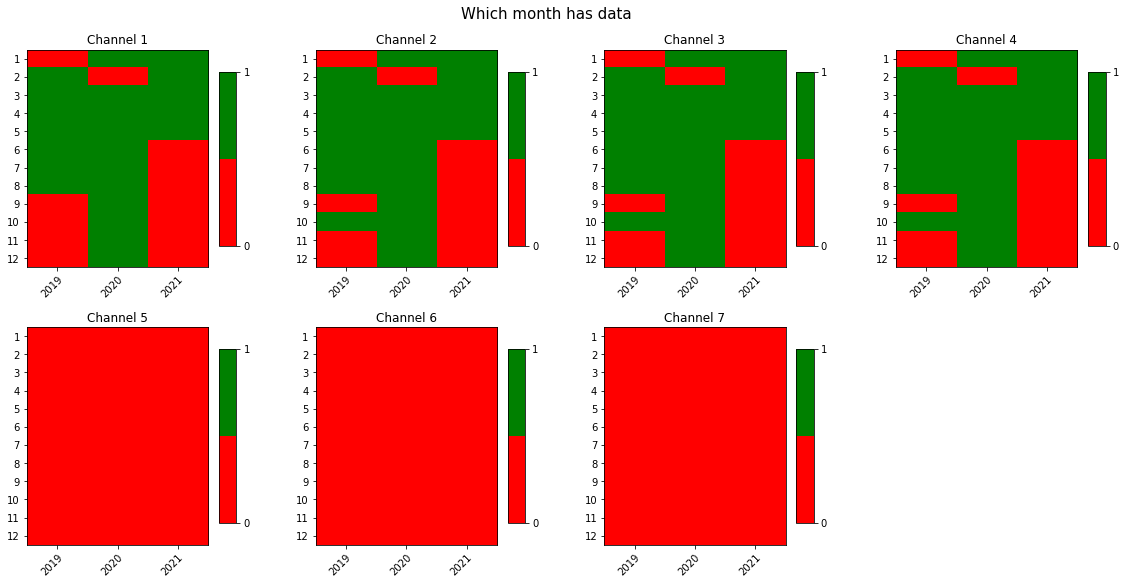

In [12]:
# alter Plot
# does not contain daniel data
# improvements: add df_unique_days_month_2019 numbers to plot
# besser anderen Graphen, x-Achse Zeit; y-Achse Messungen prt Tag --> 

# Avaible Data Overview
# 1: there was a file
# 0: there was no file

fig, axes = plt.subplots(2,4,figsize=[16,8],constrained_layout=True)
fig.suptitle("Which month has data", fontsize=15)
cmap = colors.ListedColormap(['red', 'green'])
#norm = colors.Normalize(vmin=0, vmax=1)
channel_plot=0
for ax in axes.flat[0:-1]:
    channel_plot+=1
    im = ax.imshow(data_for_month_avaible[channel_plot].to_numpy(dtype=int), cmap=cmap, aspect=0.3,vmin=0,vmax=1)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(["2019","2020","2021"])
    ax.set_yticks([0,1,2,3,4,5,6,7,8,9,10,11])
    ax.set_yticklabels([1,2,3,4,5,6,7,8,9,10,11,12])
    ax.set_title(f"Channel {channel_plot}")
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    cbar = ax.figure.colorbar(im,ax=ax,shrink=0.8,ticks=[0,1])

axes[1, 3].remove()  # don't display empty ax
#fig.tight_layout()
plt.show()

In [13]:
def all_days_of_year(year, day_format="%Y-%m-%d"):
    """returns list with all days of a year in day_format (used in .strftime)"""
    output=[]
    #A timedelta object of 1 day
    oneday = timedelta(days=1)

    #A date object of the start of the year
    current_day = date(year, 1, 1)

    #Print all the days of the given year in YYYYmmdd format
    while current_day.year == year:
        output.append(current_day.strftime(day_format))
        current_day += oneday
    return output

In [14]:
# Improve n_meas_pdy: add days where 0 measurements were made
# days with 0 measurements will occur in th new dictionaries

def improve_n_meas_pday(n_meas_pday, year):
    """returns a dic, which also has days with 0 measurements"""
    improved_n_meas_pday=defaultdict(dict)
    channelnumbers=["1","2","3","4","5","6","7","8"]
    for c in channelnumbers: # loop over each channel
        for day in all_days_of_year(year):
            if day in n_meas_pday[c].keys():
                improved_n_meas_pday[c][day] = n_meas_pday[c][day]
            else:
                improved_n_meas_pday[c][day] = 0
    return improved_n_meas_pday

#n_meas_pday_2018_with0=improve_n_meas_pday(n_meas_pday_2018, 2018)
n_meas_pday_2019_with0=improve_n_meas_pday(n_meas_pday_2019, 2019)
n_meas_pday_2020_with0=improve_n_meas_pday(n_meas_pday_2020, 2020)
n_meas_pday_2021_with0=improve_n_meas_pday(n_meas_pday_2021, 2021)

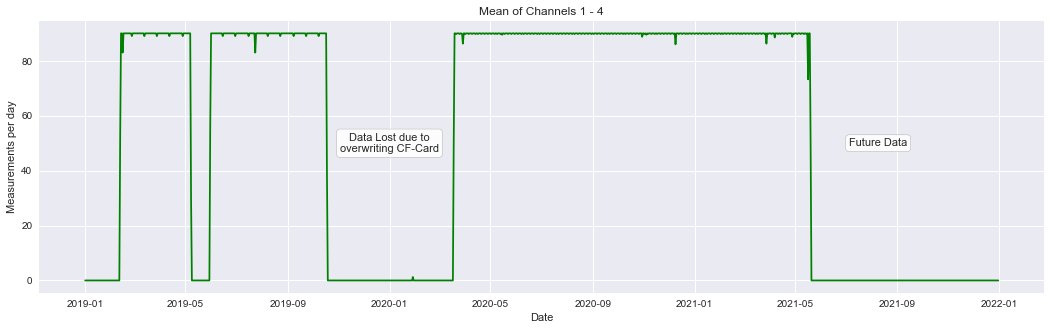

In [15]:
#Plot mean measurements per channel
def calc_mean_channels_n_pday(n_meas_pday_20xx_with0):
    """calculate the number of measurements as mean over the 4 channels"""
    val_ch1=np.array(list(n_meas_pday_20xx_with0["1"].values()))
    val_ch2=np.array(list(n_meas_pday_20xx_with0["2"].values()))
    val_ch3=np.array(list(n_meas_pday_20xx_with0["3"].values()))
    val_ch4=np.array(list(n_meas_pday_20xx_with0["4"].values()))
    mean=(val_ch1+val_ch2+val_ch3+val_ch4)/4

    # check if dates are equal
    date_ch1=pd.to_datetime(list(n_meas_pday_20xx_with0["1"]))
    date_ch2=pd.to_datetime(list(n_meas_pday_20xx_with0["2"]))
    date_ch3=pd.to_datetime(list(n_meas_pday_20xx_with0["3"]))
    date_ch4=pd.to_datetime(list(n_meas_pday_20xx_with0["4"]))
    counter_equal=0
    counter_not_equal=0
    for i in range(len(date_ch1)):
        if date_ch1[i] == date_ch2[i] and date_ch3[i] and date_ch4[i]:
            #print("all dates for mean calculation are equal")
            counter_equal+=1
    else:
        #print("dates for mean calculation are not equal!")
        #print(date_ch1[i]);print(date_ch2[i]);print(date_ch3[i]);print(date_ch4[i])
        counter_not_equal+=1
    if counter_not_equal >= 3: # 31.12. seems to be a problem? Dont know why. Not very important.
        print("check dates")
    return mean, date_ch1

#mean_2018, date_2018 = calc_mean_channels_n_pday(n_meas_pday_2018_with0)
mean_2019, date_2019 = calc_mean_channels_n_pday(n_meas_pday_2019_with0)
mean_2020, date_2020 = calc_mean_channels_n_pday(n_meas_pday_2020_with0)
mean_2021, date_2021 = calc_mean_channels_n_pday(n_meas_pday_2021_with0)

plt.style.use("seaborn")
plt.figure(figsize=[18,5])
#plt.plot(date_2018, mean_2018,color="green")
plt.plot(date_2019, mean_2019,color="green")
plt.plot(date_2020, mean_2020,color="green")
plt.plot(date_2021, mean_2021,color="green")
plt.ylabel("Measurements per day")
plt.xlabel("Date")
plt.title(f"Mean of Channels 1 - 4")

# PLOT ACCESSOIREs, Plot Patches with description
## some generel settings
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
size=11; y=50; ha="center"; va="center"
x=mdates.date2num(pd.to_datetime("01.01.2020"))
plt.text(x, y,"Data Lost due to\noverwriting CF-Card", ha=ha, va=va, size=size, bbox=bbox_props) # data lost box
# p is index of last date with 0 data from behind
p=np.argmax(mean_2021[::-1] > 0) #flip dataframe to allow single days without measurements in between others
# Needs to be UPDATED for a new year with data !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
x=mdates.date2num(pd.to_datetime(date_2021[-p] + timedelta(days=80)))
plt.text(x, y,"Future Data", ha=ha, va=va, size=size, bbox=bbox_props) # Future data box

if plot_save:
    plt.savefig("pictures/mean_of_all_channels_measpday.png")
    plt.savefig("pictures/dpi720/mean_of_all_channels_measpday_dpi720.png", dpi=720)
plt.show()

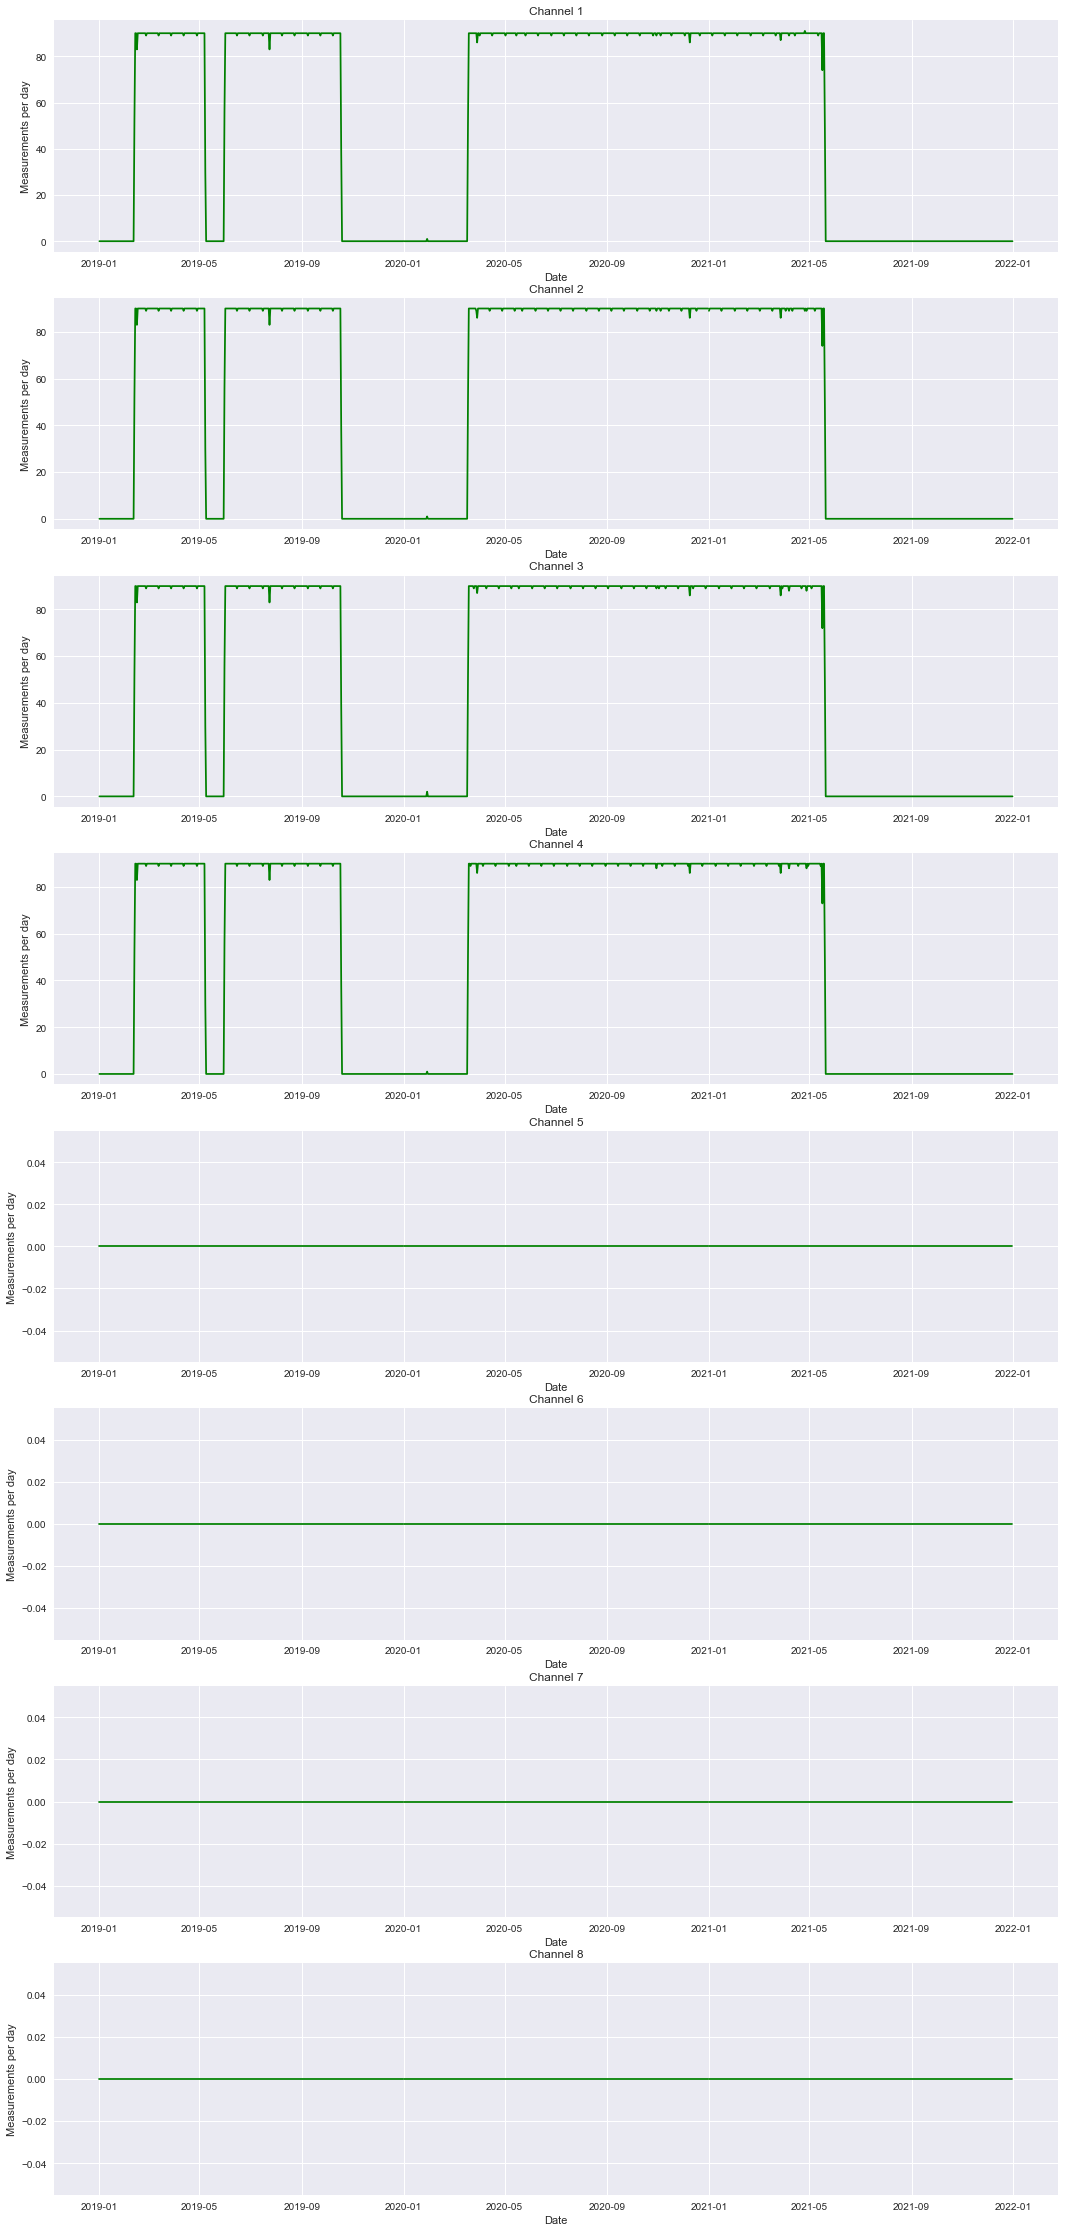

In [18]:
# Plot each channel seperate
#from cycler import cycler

plt.style.use("seaborn")
# when plotting all different channels in one plot using a loop, this cycler is handy
#plt.rc('lines', linewidth=4)
#plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y']) + cycler('linestyle', ['--', '--', '--', '--'])))
fig,axs=plt.subplots(8,1,figsize=[18,40])
for channel in ["1","2","3","4","5","6","7","8"]:
    n=int(channel)-1
    c="green"
    #axs[n].plot(pd.to_datetime(list(n_meas_pday_2018_with0[channel])), n_meas_pday_2018_with0[channel].values(),color=c)
    axs[n].plot(pd.to_datetime(list(n_meas_pday_2019_with0[channel])), n_meas_pday_2019_with0[channel].values(),color=c)
    axs[n].plot(pd.to_datetime(list(n_meas_pday_2020_with0[channel])), n_meas_pday_2020_with0[channel].values(),color=c)
    axs[n].plot(pd.to_datetime(list(n_meas_pday_2021_with0[channel])), n_meas_pday_2021_with0[channel].values(),color=c)
    axs[n].set_ylabel("Measurements per day")
    axs[n].set_xlabel("Date")
    axs[n].set_title(f"Channel {channel}")
#axs.set_prop_cycle(cycler('color', ['c', 'm', 'y', 'k']) + cycler('lw', [1, 2, 3, 4]))

if plot_save:
    plt.savefig("pictures/all_channels_measpday.png")
    plt.savefig("pictures/dpi720/all_channels_measpday_dpi720.png", dpi=720)
plt.show()
# part which was overwritten, 2019-09 till 2020-01, in sciebo are data till 2019-10.

# 90 Messungen pr Tag pro Channel is maximum: 24*60*60/90/4 = 240 s Mittelungszeitraum einer Messung
# 24*60*60: Sekunden pro Tag
# 90: Messungen pro Tag
# 4: Channel in denen gemessen wird

# Import 2018 data; different export settings
The following screenshot shows the expected settings while exporting the 2018 data. They are exported per day, for easier reading of the different cable lengths.

<img src=".\pictures\Charon4_export_window_txt_2018_day.png" alt="drawing" width="500"/>

In [19]:
# generate all requested paths, some paths may be empty
path_to_controller_2018_day=r"..\Alsdorf\Daten\Charon4\charon4_export_as_txt\2018_export_by_day"
year="2018"
paths_for_activate_2018_day={}

for channel in channels:
    for month in months:
        paths_for_activate_2018_day[f"temp_ch{channel}_year2018_month{month}"] = path_to_controller_2018_day + f"\Controller\{controller}\{channel}\Temperature Data\{year}\{month}"

#paths_for_activate_2018_day

In [20]:
def import_temp_to_df_2018(path):
    """"""
    one_file = pd.read_csv(path,decimal=".",delimiter="\t",skiprows=7,index_col=0)
    one_file = one_file.drop(one_file.columns[0:2],axis=1)
    one_file.index = pd.to_datetime(one_file.index, infer_datetime_format=True)
    one_file.rename(columns=lambda x: float(x), inplace=True) # when sampling is 0.5 m int values are not sufficient
    one_file.index.names = ['Date']
    one_file.columns.names=["Length [m]"]
    return one_file

def create_base_dataframe(n_columns,sampling_05=False):
    """"""
    if sampling_05==False: #sampling interval is 1 m
        df=pd.DataFrame(columns=np.linspace(0,n_columns-1,n_columns))
        df.rename(columns=lambda x: float(x), inplace=True) #to have all 2018 data data as float
    if sampling_05==True:
        df=pd.DataFrame(columns=np.linspace(0,(n_columns-1)/2,n_columns))
    df.index.names = ['Date']
    df.columns.names=["Length [m]"]
    return df

In [21]:
%%time
#Wall time: 2min 17s

# TO-DO !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# check if one day folder contains more than one file

# create dic depending on channelnumber and cable length
cable_lengths_2018=[233,1314,2340,1171,1170,798,259,799,268,1352,676,223,378,250,800]
#all_files=defaultdict(dict) #two level defaultdict
#all_files = defaultdict(lambda: defaultdict(dict)) ##two level defaultdict, different style
# data_2018_day, is named day because the data is exported different from Charon4, than the data from the other years
data_2018_day=my_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(dict))) #three level defaultdict
for channel in channels:
    for cable_type in cable_lengths_2018:
        for month in months:

            if cable_type != 2340 and 1352: # sampling interval is 1 m
                data_2018_day[cable_type][str(channel)][str(month)] = create_base_dataframe(cable_type)

            else: #sampling interval is 0.5 m instead of 1 m
                data_2018_day[cable_type][str(channel)][str(month)] = create_base_dataframe(cable_type,sampling_05=True)

count_ParserError=0
for channel in channels:
    for month in months: #path could be empty --> no data 
        my_path=paths_for_activate_2018_day[f"temp_ch{channel}_year2018_month{month}"]
        all_my_paths=get_abspath(my_path + "\*\*") 

        for file in all_my_paths:
            # check cable length and create different dataframes

            try: 
                # Read Data
                one_file = import_temp_to_df_2018(file)

                #check cable length and put it in corresponding dataframe
                n_columns=len(one_file.columns)
                data_2018_day[n_columns][str(channel)][str(month)]=pd.concat([data_2018_day[n_columns][str(channel)][str(month)],one_file],axis=0)
                # doppelte datums tauchen auf

            # except ParserError, file contains data with different cable lengths
            # With this solution I will skip these data.
            except pd.errors.ParserError:
                count_ParserError+=1
                pass

print(f"{count_ParserError} ParserErrors were skipped. This means {count_ParserError} days with data are not read!")        

2 ParserErrors were skipped. This means 2 days with data are not read!
Wall time: 2min 26s


In [22]:
# remove empty dataframes and delete the corresponding key, so my previous defined functions can be used
# without list() RuntimeError: dictionary changed size during iteration occurs
for cable_type in list(data_2018_day.keys()):
    for channel in list(data_2018_day[cable_type].keys()):
        for month in list(data_2018_day[cable_type][channel].keys()):

            if data_2018_day[cable_type][channel][month].shape[0] == 0: # number pf rows of dataframe 0 == empty
                del data_2018_day[cable_type][channel][month] # month key will be deleted

#difference to other years:
# different cable length exists --> they have there own key in dic
# column names are not int; due to sampling interval of 0.5 m in some cable length

# count meas per day variables for 2018_day
df_unique_days_month_2018_day={}
n_meas_pday_2018_day={}
n_meas_pday_2018_day_with0={}
for cable_type in cable_lengths_2018:
    df_unique_days_month_2018_day[cable_type], n_meas_pday_2018_day[cable_type] = calculate_measurements_per_day(data_2018_day[cable_type])
    n_meas_pday_2018_day_with0[cable_type] = improve_n_meas_pday(n_meas_pday_2018_day[cable_type] , year=2018)


2018-11-16 has less than 10 measurements per day in channel 1
2018-11-09 has less than 10 measurements per day in channel 2
2018-11-09 has less than 10 measurements per day in channel 6


In [23]:
%%time
#Wall time: 49.1 s

# Save Data 2018
if data_save:
    save_to_path = path_to_controller + r"\..\..\my_database\temp_2018_Controller3188"
    #path_to_controller + "\..\..\my_database"
    for cable_length in data_2018_day.keys():
        for channel in data_2018_day[cable_length].keys():

            if cable_length != 2340 and 1352: # sampling interval is 1 m
                data_2018_day_save = create_base_dataframe(cable_length)
            else: #sampling interval is 0.5 m instead of 1 m
                data_2018_day_save = create_base_dataframe(cable_length,sampling_05=True)

            for month in data_2018_day[cable_length][channel].keys():
                one_file = data_2018_day[cable_length][channel][month]
                data_2018_day_save = pd.concat([data_2018_day_save , one_file],axis=0)
        
            # Save data
            if data_2018_day_save.shape[0]!=0: # dataframe contains rows (with data)
                filename=f"\\temp_cablelength{cable_length}_ch{channel}.csv"
                data_2018_day_save.to_csv(save_to_path + filename)

Wall time: 50.3 s


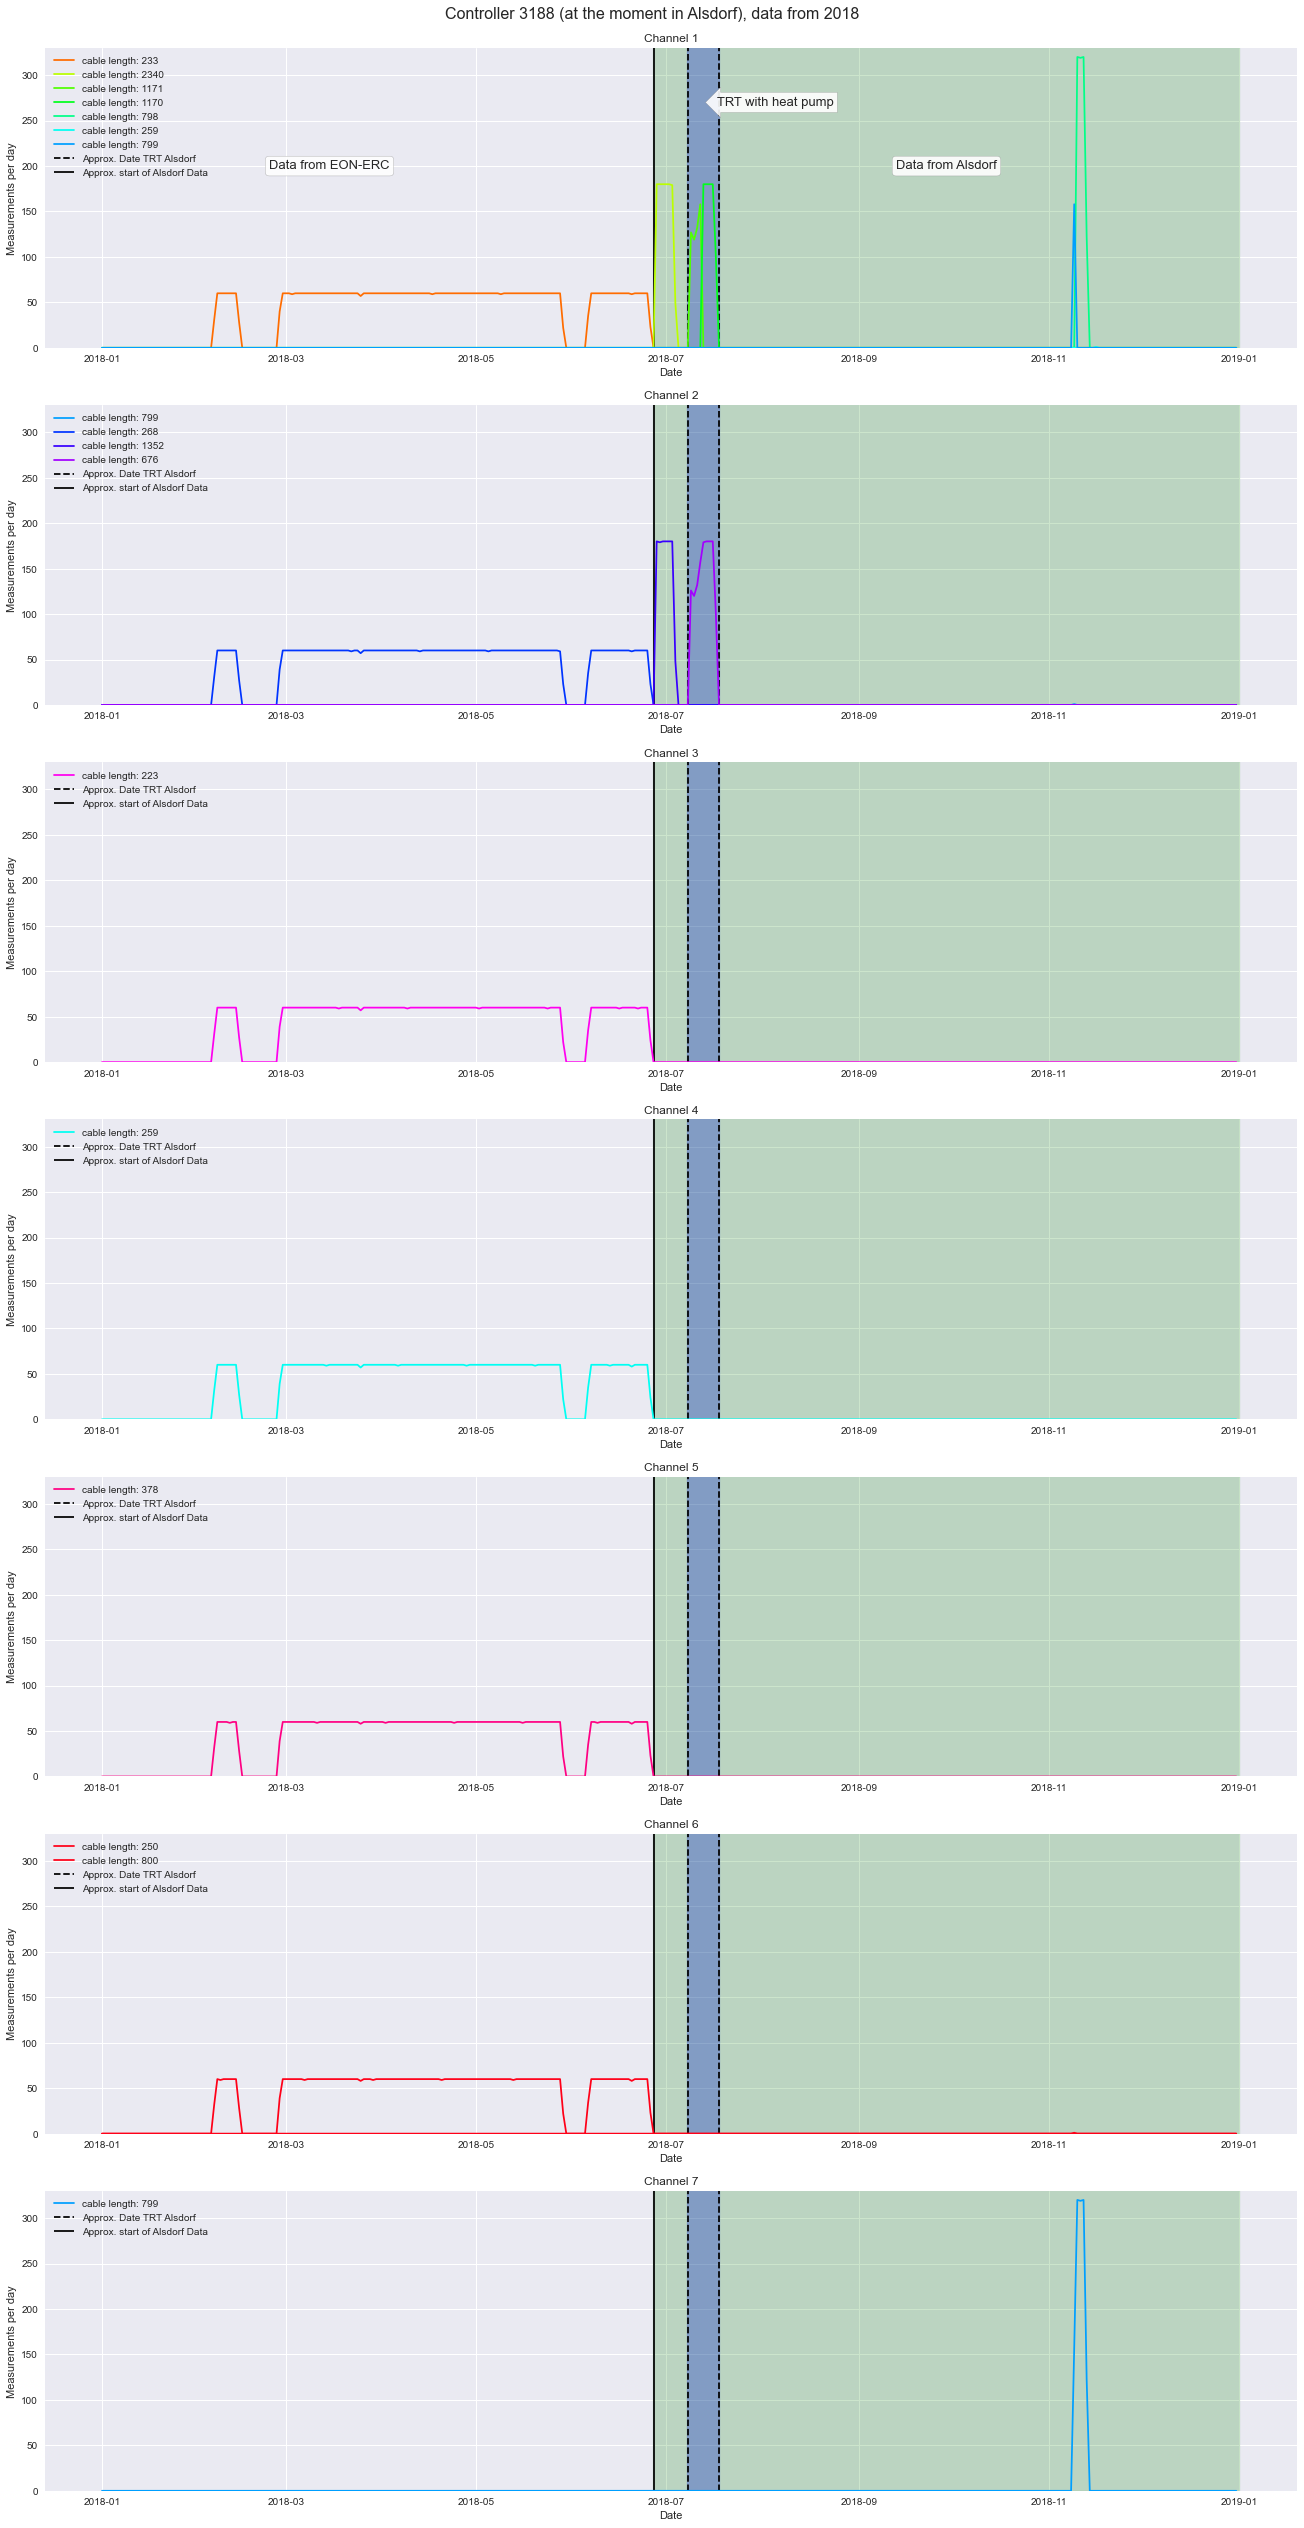

Cable length 2340 and 1352 have a measuring interval of 0.5 m; all other a interval of 1 m
Both of these are shortly before the TRT at 9-10 Juli 2018 (info from Norbert)
All data before should be from EON-ERC (rather a guess). This means data before 27.06.2018


In [24]:
# Plot 2018_day data
#plot wie oben für 2018 generieren. Jede Kabellänge andere Farbe.

# Plot each channel seperate

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

plt.style.use("seaborn")
fig,axs=plt.subplots(7,1,figsize=[18,35],constrained_layout=True)
fig.suptitle("Controller 3188 (at the moment in Alsdorf), data from 2018", fontsize=16)
c=get_cmap(len(cable_lengths_2018))
for channel in ["1","2","3","4","5","6","7"]:
    n=int(channel)-1

    axs[n].set_ylim(0,330)
    axs[n].set_ylabel("Measurements per day")
    axs[n].set_xlabel("Date")
    axs[n].set_title(f"Channel {channel}")

    # PLOT ACCESSOIREs
    # Plot date of TRT 9-10 Juli 2018, these somehow mark the first measurements in Alsdorf (info from Norbert)
    start_time_trt=mdates.date2num(pd.to_datetime("07.08.2018"))
    end_time_trt=mdates.date2num(pd.to_datetime("07.18.2018"))
    width_trt= end_time_trt - start_time_trt
    fancy_box=patches.FancyBboxPatch(xy=[start_time_trt,0],width=width_trt,height=350,color="blue",alpha=0.3,boxstyle='square')
    axs[n].add_patch(fancy_box)
    axs[n].vlines(start_time_trt, ymin=0, ymax=330, label="Approx. Date TRT Alsdorf", colors="black",linestyles="--")
    axs[n].vlines(end_time_trt, ymin=0, ymax=330, colors="black",linestyles="--")
    # Plot Approximated beginn of Alsdorf Data
    start_time_alsd=mdates.date2num(pd.to_datetime("06.27.2018"))
    end_time_alsd=mdates.date2num(pd.to_datetime("01.01.2019"))
    width_alsd = end_time_alsd - start_time_alsd
    axs[n].vlines(start_time_alsd, ymin=0, ymax=330, label="Approx. start of Alsdorf Data", colors="black",linestyles="-")
    fancy_box=patches.FancyBboxPatch(xy=[start_time_alsd,0],width=width_alsd,height=350,color="green",alpha=0.2,boxstyle='square')
    axs[n].add_patch(fancy_box)

    # PLOT MEASUREMENTS PER DAY OF DATA
    counter=0
    for cable_type in cable_lengths_2018:
        counter+=1
        # only plot data which have at least one measurement
        if max(n_meas_pday_2018_day_with0[cable_type][channel].values()) > 0: 
            axs[n].plot(pd.to_datetime(list(n_meas_pday_2018_day_with0[cable_type][channel])), n_meas_pday_2018_day_with0[cable_type][channel].values(), color=c(counter), label=f"cable length: {cable_type}")
    
    axs[n].legend()

# Plot Patches only in forst axes
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
size=13; y=200; ha="center"; va="center"
# Plot data which is expected to be from EON-ERC
start_time_eon=mdates.date2num(pd.to_datetime("12.01.2017"))
width_eon=start_time_alsd - start_time_eon
x = start_time_eon + 0.5 * width_eon
axs[0].text(x, y,"Data from EON-ERC", ha=ha, va=va, size=size, bbox=bbox_props)
x = start_time_alsd + 0.5 * width_alsd
axs[0].text(x, y,"Data from Alsdorf", ha=ha, va=va, size=size, bbox=bbox_props)
bbox_props = dict(boxstyle="larrow", fc="w", ec="0.5", alpha=0.9)
x = end_time_trt + 1.8* width_trt
axs[0].text(x, 270,"TRT with heat pump", ha=ha, va=va, size=size, bbox=bbox_props)

if plot_save:
    plt.savefig("pictures/all_channels_measpday_2018.png")
    plt.savefig("pictures/dpi720/all_channels_measpday_2018_dpi720.png", dpi=720)
plt.show()

print("Cable length 2340 and 1352 have a measuring interval of 0.5 m; all other a interval of 1 m")
print("Both of these are shortly before the TRT at 9-10 Juli 2018 (info from Norbert)")
print("All data before should be from EON-ERC (rather a guess). This means data before 27.06.2018")

In [25]:
# To do

# adjust everything, so that it works for channel 1 to 8, because the new data will be also in the channels 5,6,7,8
#   in mean meas per day bereiche markieren und patch hinzufügen indem steht wann EGRT Kabel angeschlossen wurde

# divide notebook into two
#   one which only imports and saves data
#   another one which analyses (plots) the data
#   atleast create a seperate script for plotting, maybe also keep some plots in the import script
#   maybe 2018 data seperate notebook too
